In [14]:
%tensorflow_version 2.x
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early = EarlyStopping(monitor='val_loss', patience=6, verbose=1)
lr_decay = ReduceLROnPlateau(monitor='val_loss', 
                             patience=3, verbose=1, 
                             factor=0.5, min_lr=1e-4)
%matplotlib inline


print("Tesorflow Version:", tf.__version__)
print("Keras Version:",keras.__version__)

Tesorflow Version: 2.0.0
Keras Version: 2.2.4-tf


In [2]:
!wget https://www.dropbox.com/s/drwy7fq5svwv78p/101_ObjectCategories_split.tar
!tar xf 101_ObjectCategories_split.tar
!rm 101_ObjectCategories_split.tar

--2019-12-25 21:49:33--  https://www.dropbox.com/s/drwy7fq5svwv78p/101_ObjectCategories_split.tar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.1, 2620:100:6025:1::a27d:4501
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/drwy7fq5svwv78p/101_ObjectCategories_split.tar [following]
--2019-12-25 21:49:33--  https://www.dropbox.com/s/raw/drwy7fq5svwv78p/101_ObjectCategories_split.tar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucae752f8e4e4d4391f06078c72d.dl.dropboxusercontent.com/cd/0/inline/Au5b6eSOvQmu6A9GaMJM0byoCcfvOAFnexMHGUFLYKSLdJdN8SHovqmKjG0ddUOQRUVEutx6ISxcujwYTRm5dHuIzbPgSzvPvOQrBkMd7mI-WQ/file# [following]
--2019-12-25 21:49:34--  https://ucae752f8e4e4d4391f06078c72d.dl.dropboxusercontent.com/cd/0/inline/Au5b6eSOvQmu6A9GaMJM0byoCcfvOAFnexMHGUFLYKSLdJdN8SHovqmKjG0ddUOQRUVEutx6ISxcuj

In [4]:
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras.applications import vgg16

# Training with Data Augmentation

**In this part we use the image generator of keras, the images are processed while being called by these generators, in particular we use the vgg16 preprocessing function, since we are using the vgg16 model and the image can randomaly rotate of any angle between -30 and 30, it can have increased or decreased brightess, it can be flipped horizontally or verically and can be randomly zoomed in up to 50\%.**

**While the test images are only preprocessed using the vgg16 preprocess functions.**

In [29]:
train_processing = kimage.ImageDataGenerator(rotation_range=30, brightness_range=[0.4,1.4],
                                             horizontal_flip=True, vertical_flip=True,
                                             zoom_range=[0.5,1.0],
                                             preprocessing_function=vgg16.preprocess_input)
train_generator = train_processing.flow_from_directory('101_ObjectCategories_split/train', 
                                                       target_size=(224,224), 
                                                       batch_size=100,
                                                       seed=1, 
                                                       shuffle=True)


test_processing = kimage.ImageDataGenerator(
    preprocessing_function=vgg16.preprocess_input)
test_generator = test_processing.flow_from_directory('101_ObjectCategories_split/test', 
                                                     target_size=(224,224), 
                                                     batch_size=100,
                                                     seed=1, 
                                                     shuffle=True)

Found 4600 images belonging to 102 classes.
Found 4544 images belonging to 102 classes.


**We take the VGG16 model as the feature extractor and the last layer (without the top) has an global average pooling applied to it.**

In [ ]:
model = vgg16.VGG16(include_top=False, weights='imagenet', 
                    pooling='avg', input_shape = (224, 224, 3))

**3 FC layers are added, the first one with 1024 neurons with relu function, the second one with 512 neurons with relu functions and the last one is the output layer with 102 neurons (number of classes) with softmax activation function.**

**The optimizer is the SGD with nesterov momentum and the loss is the categorical crossentropy.**

**The ReduceLROnPlateau and EarlyStopping callbacks are used.**

In [ ]:
for layer in model.layers:
  layer.trainable = False

x = Dense(1024, activation='relu')(model.output)
x = Dense(512, activation='relu')(x)
pred = Dense(102, activation='softmax')(x)

net = Model(model.input, pred)
net.compile(loss='categorical_crossentropy', 
            optimizer=tf.keras.optimizers.SGD(learning_rate=0.05, nesterov=True, momentum=0.5), 
            metrics=['accuracy']) 

In [32]:
len(model.layers)

20

In [33]:
net.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [34]:
history = net.fit_generator(train_generator, 
                            epochs=30, 
                            validation_data=test_generator,
                            validation_steps=20, #not all the validation set but approximately 45% of it
                            callbacks=[lr_decay, early])

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 46 steps, validate for 20 steps
Epoch 1/30
46/46 [==============================] - 77s 2s/step - loss: 3.7119 - accuracy: 0.3989 - val_loss: 1.5593 - val_accuracy: 0.6380
Epoch 2/30
46/46 [==============================] - 77s 2s/step - loss: 1.4161 - accuracy: 0.6398 - val_loss: 1.1646 - val_accuracy: 0.6940
Epoch 3/30
46/46 [==============================] - 76s 2s/step - loss: 1.0162 - accuracy: 0.7270 - val_loss: 1.0029 - val_accuracy: 0.7220
Epoch 4/30
46/46 [==============================] - 77s 2s/step - loss: 0.8187 - accuracy: 0.7802 - val_loss: 0.8710 - val_accuracy: 0.7555
Epoch 5/30
46/46 [==============================] - 76s 2s/step - loss: 0.6562 - accuracy: 0.8152 - val_loss: 0.7082 - val_accuracy: 0.8130
Epoch 6/30
46/46 [==============================] - 76s 2s/step - loss: 0.5478 - accuracy: 0.8443 - val_loss: 0.6970 - val_accuracy: 0.8245
Epoch 7/30
46/46 [==============================] - 76s 2s/step - loss: 0.4969 - accuracy: 0.8548 - val_loss: 0.6801 -

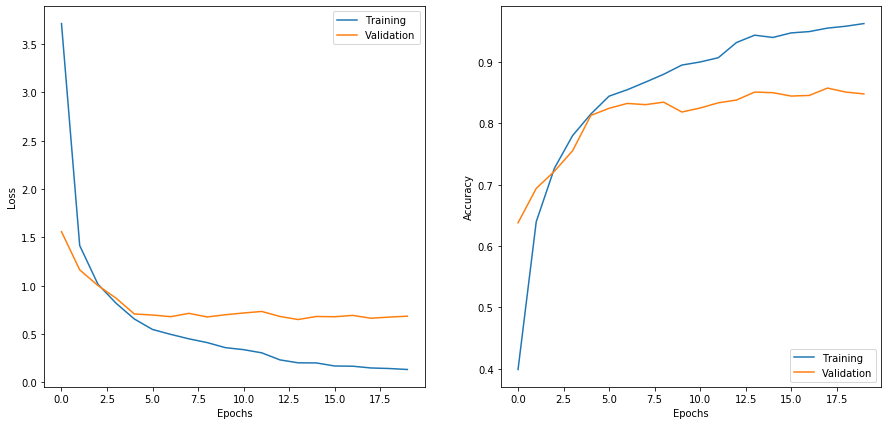

In [35]:
plt.figure(figsize=(15,7))
ax1 = plt.subplot(121)
plt.xlabel('Epochs')
plt.ylabel('Loss')
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['Training', 'Validation'])

ax2 = plt.subplot(122)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['Training', 'Validation'], loc='lower right')
plt.show()

In [36]:
net.evaluate(test_generator)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


46/46 [==============================] - 26s 571ms/step - loss: 0.6617 - accuracy: 0.8497


[0.6616553353226703, 0.8496919]

# Training without Data Augmentation

**Now we try the same model as above but without any data augmentation except for the preprocess function of VGG16, the models remains the same with the same hyper-parameters.**

In [37]:
train_processing = kimage.ImageDataGenerator(preprocessing_function=vgg16.preprocess_input)
train_generator = train_processing.flow_from_directory('101_ObjectCategories_split/train', 
                                                       target_size=(224,224), 
                                                       batch_size=100,
                                                       seed=1, 
                                                       shuffle=True)


test_processing = kimage.ImageDataGenerator(
    preprocessing_function=vgg16.preprocess_input)
test_generator = test_processing.flow_from_directory('101_ObjectCategories_split/test', 
                                                     target_size=(224,224), 
                                                     batch_size=100,
                                                     seed=1, 
                                                     shuffle=True)

Found 4600 images belonging to 102 classes.
Found 4544 images belonging to 102 classes.


In [ ]:
x = Dense(1024, activation='relu')(model.output)
x = Dense(512, activation='relu')(x)
pred = Dense(102, activation='softmax')(x)

net2 = Model(model.input, pred)
net2.compile(loss='categorical_crossentropy', 
            optimizer=tf.keras.optimizers.SGD(learning_rate=0.05, nesterov=True, momentum=0.5), 
            metrics=['accuracy']) 

In [41]:
history = net2.fit_generator(train_generator, 
                            epochs=30, 
                            validation_data=test_generator,
                            validation_steps=20,
                            callbacks=[lr_decay, early])

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 46 steps, validate for 20 steps
Epoch 1/30
46/46 [==============================] - 39s 841ms/step - loss: 4.3505 - accuracy: 0.5028 - val_loss: 1.0994 - val_accuracy: 0.7160
Epoch 2/30
46/46 [==============================] - 38s 836ms/step - loss: 0.6392 - accuracy: 0.8391 - val_loss: 0.7531 - val_accuracy: 0.8075
Epoch 3/30
46/46 [==============================] - 38s 837ms/step - loss: 0.2956 - accuracy: 0.9259 - val_loss: 0.5648 - val_accuracy: 0.8470
Epoch 4/30
46/46 [==============================] - 39s 837ms/step - loss: 0.1249 - accuracy: 0.9770 - val_loss: 0.5756 - val_accuracy: 0.8615
Epoch 5/30
46/46 [==============================] - 39s 838ms/step - loss: 0.0577 - accuracy: 0.9922 - val_loss: 0.5070 - val_accuracy: 0.8715
Epoch 6/30
46/46 [==============================] - 39s 840ms/step - loss: 0.0415 - accuracy: 0.9937 - val_loss: 0.4895 - val_accuracy: 0.8795
Epoch 7/30
46/46 [==============================] - 39s 840ms/step - loss: 0.0249 - accuracy: 0.9970

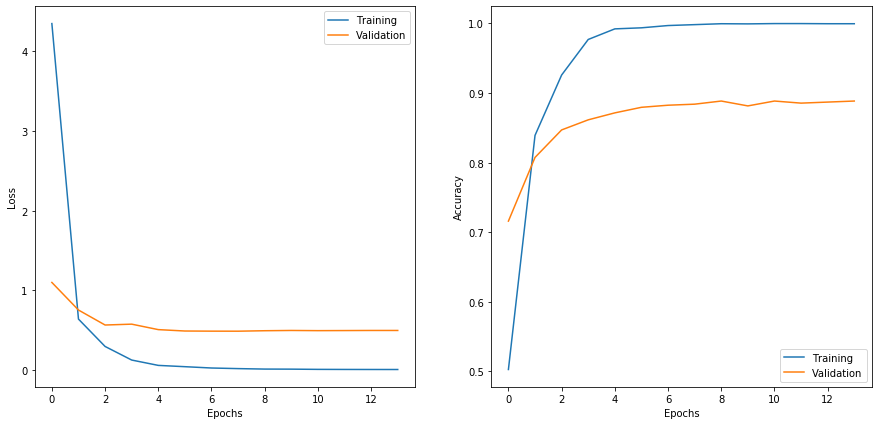

In [42]:
plt.figure(figsize=(15,7))
ax1 = plt.subplot(121)
plt.xlabel('Epochs')
plt.ylabel('Loss')
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['Training', 'Validation'])

ax2 = plt.subplot(122)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['Training', 'Validation'], loc='lower right')
plt.show()

In [43]:
net2.evaluate(test_generator)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


46/46 [==============================] - 26s 574ms/step - loss: 0.4747 - accuracy: 0.8869


[0.47472468229091686, 0.8868838]

# Conclusions

The model accuracy are reported in the following table:

| Model              | Data Augmentation | No Data Aumentation |
|--------------------|:-----------------:|:-------------------:|
| Train Accuracy     | $0.9626$          | $0.9996$            |
| Validation Accuracy| $0.8497$          | $0.8869$            |

In both model we can see the overfitting fenomena on the training set, but in the model without data augmentation the model adapts perfectly on the training data, in fact, the model with data augmentation tackles this problem by providing on each epoch the same images with new random augmentations, changing them a little bit.

The data augmentation is really helpful to reduce overfitting a little bit and in the case where the training set is not completely representative, for example the training set has only images with perfect lightings or with the object if interest always centered. But the data augmentation needs to be used cautiously for example in the case of alphabets/number classification horizontal/vertical flipping can convert the letter 'd' into 'b' or the number '9' into '6' (and viceversa).

In this case the validation set is very similar to the training set, this was checked manually, probably they are two spilts of a bigger dataset, thus it makes the model without data augmentation adapt faster to the validation set. For example checking the images of the airplanes we can immediately see that all planes have their nose pointing at the right and the images lower border is parallel to the plane or in the case of the bass fish the images are also rotated so that the bass is parallel to the lower border of the image and it always faces left, so doing the rotation and flipping augmentation can cause performance degradance on the validation set as well, but acutally we are creating a more robust model.

In [36]:
from PIL import Image
import os, os.path

imgs = []
path = "101_ObjectCategories_split/train/scissors"
for f in os.listdir(path):
    imgs.append(Image.open(os.path.join(path,f)))
    
val_imgs = []
path = "101_ObjectCategories_split/test/scissors"
for f in os.listdir(path):
    val_imgs.append(Image.open(os.path.join(path,f)))

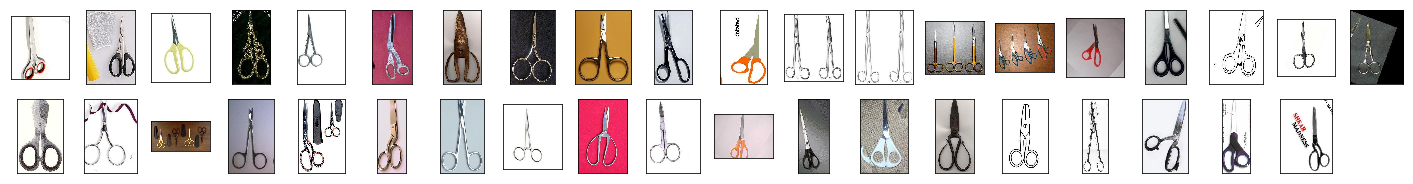

In [37]:
n = len(imgs)
plt.figure(figsize=(25,3))
for i in range(n):
    # original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(imgs[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    if i < len(val_imgs):
        ax = plt.subplot(2, n, i + 1 + n)
    
        plt.imshow(val_imgs[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
plt.show()

In the images above we can see the examples of the similarity in the training and validation set, in particular for the scissor class, the first line is the training set and the second line is the validation set, the scissors are always pointing up, and in case they are not the image is rotated to obtain the desired scirssor direction (last image of the first line).

In this fine tuning procedure we didn't optimize neither the cut nor the hyper parameters, which would have been very expensive computationally.